In [1]:
## Computes and plots FFTs of all .csv files in /data/korolev/
#IGNORES SURFACE RETURN ~first 20 px of data

###TODO: ADD MORE DATA
#TODO: change x axis to depth in m assuming a dielectric of water ice

In [2]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import pandas as pd
import glob #allegedly this helps access files
from radarfuncs import *
from lmfit.models import SkewedGaussianModel


real data mean: 0.00015106086158504824
syn[0] data mean: 0.00015106086158504827
real data var: 1.790708589742583e-07
syn[0] data var: 1.7907085897425832e-07


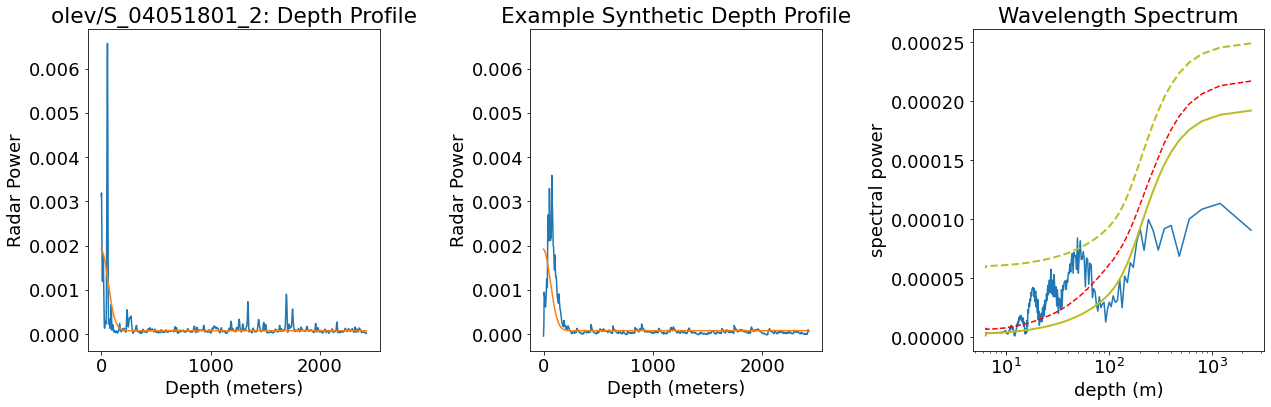

real data mean: 0.0001723161274224917
syn[0] data mean: 0.0001723161274224917
real data var: 1.230852676945982e-07
syn[0] data var: 1.2308526769459829e-07


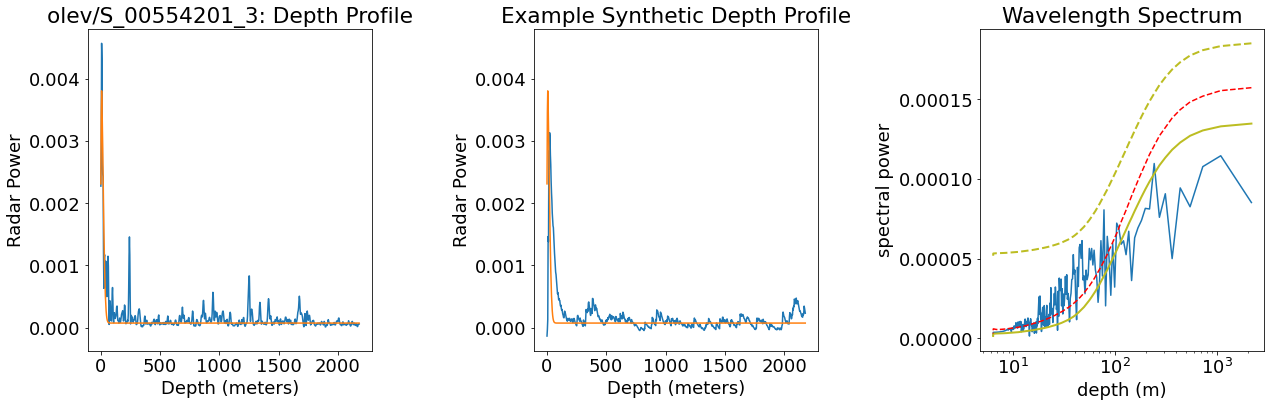

real data mean: 0.00015290662194738898
syn[0] data mean: 0.000152906621947389
real data var: 1.5161655207599e-07
syn[0] data var: 1.5161655207599e-07


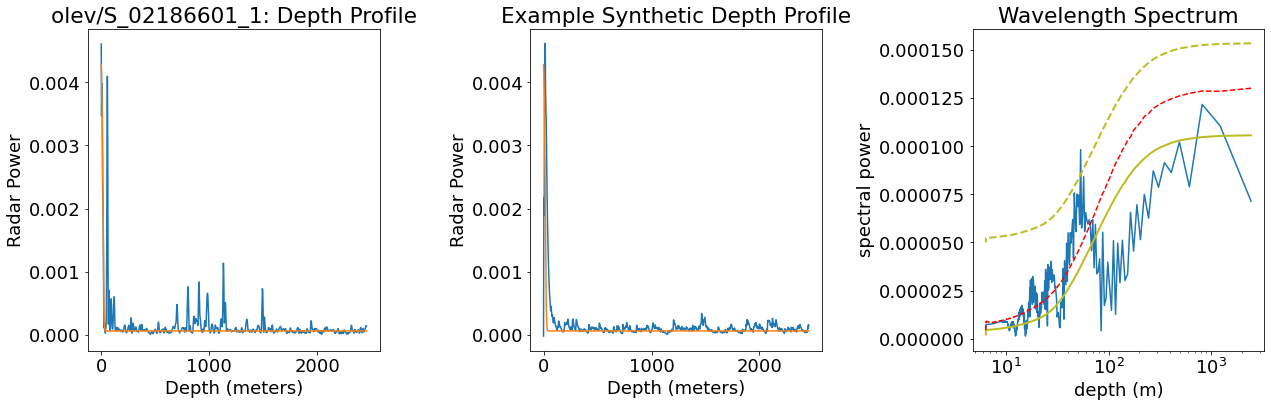

real data mean: 9.628079634454439e-05
syn[0] data mean: 9.628079634454439e-05
real data var: 1.3284890562430619e-08
syn[0] data var: 1.3284890562430612e-08


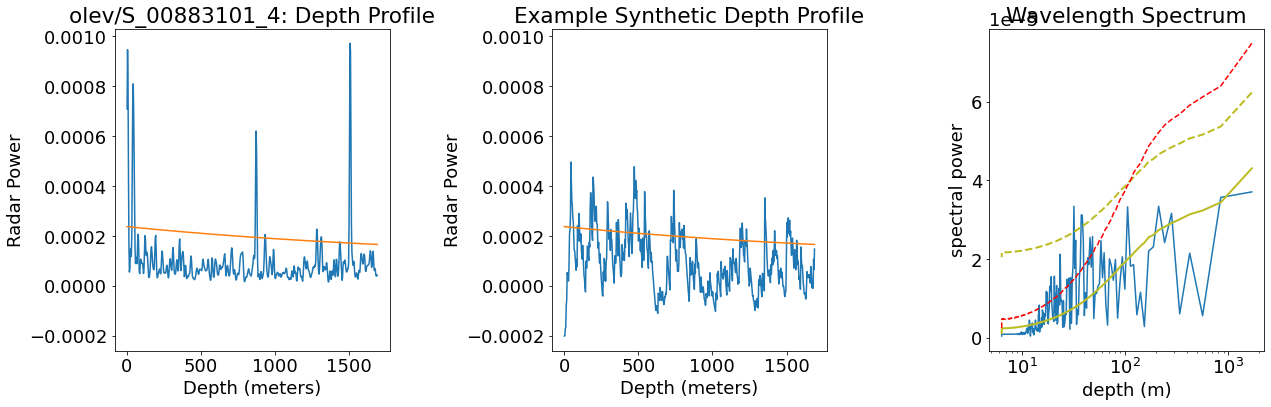

real data mean: 9.510326562682724e-05
syn[0] data mean: 9.510326562682723e-05
real data var: 4.712619691458387e-09
syn[0] data var: 4.712619691458386e-09


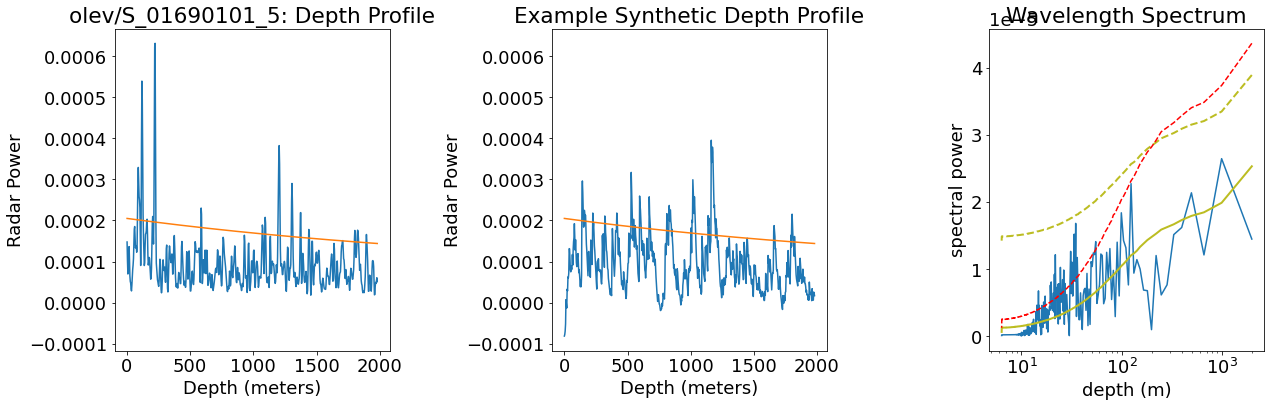

Number of datasets: 5


In [12]:
#Import csv files
csv_import = glob.glob("data/korolev/*zoom.csv")

column_names = ['depth', 'value']
csv_list = []

#compute ffts, add red noise lines to each fft plot
for i in csv_import:
    csv = pd.read_csv(i, names=column_names, skiprows=2) #skips headers
    csv_list.append(csv)
    
    x = csv.depth.to_list()
    y = csv.value.to_list()
    
    peak = y.index(max(y[0:50])) #finds surface return
    surf = x[peak] #location of surface return
    
    x = x[peak+5:]
    y = y[peak+5:]
    
    if len(x) % 2 != 0:
        x.pop()
        y.pop()
        
    #convert pixels to meters
    x = p2m_waterice(x)
    
    ##compute line to fit synthetic data to
    # Skewed Gaussian fit
    model = SkewedGaussianModel()
    params = model.make_params(amplitude=(max(y)), center=min(x)+20, sigma=20, gamma=1.5)
    result = model.fit(y, params, x=x)
    fit = result.best_fit +np.mean(y[-150:]) # prevents fit from damping out all of the noise on right-handed side

    #run fft 
    w, P1 = fft_radar(x,y)
    
    #Compute monte carlo red noise
    ft = [] #holds fourier transforms for each of 20000 random synthetic records
    syn = []

    for a in range(20000):
        r=ar1(x,y,fit) #this creates a random synthetic record with similar properties
        syn.append(r)
        w2, p = fft_radar(x,r)
        ft.append(p)
    
    plt.rcParams.update({'font.size': 18})
    #plot depth plot
    plt.figure(figsize = (18, 6))
    plt1 = plt.subplot(131)
    plt1.plot(x, y)
    plt1.plot(x, fit, color = 'C1')
    plt1.set_title(i[8:-8]+": Depth Profile")
    plt1.set_ylabel('Radar Power')
    plt1.set_xlabel('Depth (meters)')

    #plot example synthetic spectra
    plt2 = plt.subplot(132, sharey=plt1)
    plt2.plot(x, syn[0])
    plt2.plot(x, fit, color = 'C1')
    plt2.set_title('Example Synthetic Depth Profile')
    plt2.set_ylabel('Radar Power')
    plt2.set_xlabel('Depth (meters)')
    
    print("real data mean: "+ str(np.mean(y)))
    print("syn[0] data mean: "+ str(np.mean(syn[0])))
    print("real data var: "+str(np.var(y)))
    print("syn[0] data var: "+ str(np.var(syn[0])))
    
    #plot spectrum
    plt3 = plt.subplot(133)
    plt3.plot(w, P1)
    plt3.plot(w,np.mean(ft, axis=0), 'C8', linewidth = 2)
    plt3.plot(w,np.mean(ft, axis=0)+2*np.std(ft),'C8',ls='dashed', linewidth = 2)
    plt3.plot(w,np.percentile(ft, 95, axis=0),'r',ls='dashed')
    plt3.set_title('Wavelength Spectrum')
    plt3.set_xscale('log')
    plt3.set_xlabel('depth (m)')
    plt3.set_ylabel('spectral power') #units are whatever JMARS reports, I have to look into this
    plt.tight_layout()
    plt.show()
    
    #sig = np.mean(ft, axis=0)+2*np.std(ft)
    sig = np.percentile(ft, 99, axis=0)
    sig_list = []
    
    for i in range(len(P1)):
        if P1[i] > sig[i]:
            sig_list.append((w[i], P1[i]))
            #print(w[i], P1[i])

print("Number of datasets: " +str(len(csv_list)))
